# Bulk segregant analysis in yeast
20170128 Jue Wang (juewang@post.harvard.edu), Updated 20210316

## Overview
This is an example bulk segregant analysis pipeline to identify quantitative trait loci (QTLs) underlying a trait difference between 2 yeast strains. More explanation can be found in the related [blog post](https://diauxicshift.wordpress.com/2017/02/05/tutorial-bulk-segregant-analysis-in-yeast/). The biological study this example is taken from is [Lee, Wang, et al. 2017](https://journals.plos.org/plosgenetics/article?rev=2&id=10.1371/journal.pgen.1006766).

The experiment was as follows:
 - I crossed 2 strains, YJM978 and BC187, that differ in a phenotype (expression of a YFP reporter driven by GAL1 promoter), and sporulated the hybrid. Using a mating-type selection marker system, I isolated pools of MATa haploid segregants.
 - Using FACS, I isolated a pool of segregants with low reporter expression (YJM978-like phenotype) or high expression (BC187-like phenotype).
 - I sequenced the sorted pools in bulk to a depth of 20-50x.

I preprocessed the read data by aligning against the [`sacCer3`](http://hgdownload.cse.ucsc.edu/downloads.html#yeast) reference genome (using `bwa mem`) and calling variants (identifying SNPs and indels, using `samtools mpileup`). There is some room for creativity in these steps, but you can see the commands I used in [`map_reads.sh`](read_alignment_variant_calling_scripts/map_reads.sh) and [`callvar_4sample.sh`](read_alignment_variant_calling_scripts/callvar_4sample.sh).

The code below will:
1. Load the variant calls, extract the high-quality SNPs, and determine parental allele counts at each SNP for each segregant pool.
2. Plot parental allele frequencies in each pool across the genome.
3. Use [MULTIPOOL](https://github.com/matted/multipool) to compute a LOD score for allele-frequency-difference across the genome.
4. Plot MULTIPOOL LOD scores across the genome.
5. Plot gene annotations in a LOD-support interval for a significant QTL.

## References

Lee, K. B., Wang, J., Palme, J., Escalante-Chong, R., Hua, B., Springer, M. (2017). Polymorphisms in the yeast galactose sensor underlie a natural continuum of nutrient-decision phenotypes. PLoS Genetics, 13(5): e1006766. https://doi.org/10.1371/journal.pgen.1006766

Albert, F. W., Treusch, S., Shockley, A. H., Bloom, J. S., & Kruglyak, L. (2014). Genetics of single-cell protein abundance variation in large yeast populations. Nature, 506(7489), 494–7. http://doi.org/10.1038/nature12904

Treusch, S., Albert, F. W., Bloom, J. S., Kotenko, I. E., & Kruglyak, L. (2015). Genetic Mapping of MAPK-Mediated Complex Traits Across S. cerevisiae. PLoS Genet., 11(1), e1004913. http://doi.org/10.1371/journal.pgen.1004913

Edwards, M. D., & Gifford, D. K. (2012). High-resolution genetic mapping with pooled sequencing. BMC Bioinformatics, 13 Suppl 6(Suppl 6), S8. http://doi.org/10.1186/1471-2105-13-S6-S8

## Imports
We use `pandas` DataFrames for storing the SNP tables, `numpy` to do math, and `matplotlib` for plots.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
datadir = 'data/'
figdir = 'fig/'

## Load SNP data
The data are in .vcf files generated by `samtools mpileup`.

The general plan is to load them into pandas DataFrames, look at the data while filtering / processing them, and then write a function that will automate this process for future datasets.

### Load VCF

In [22]:
filename = datadir+'GxB.vcf'

find first line of variant table

In [23]:
nhead = 0
for line in open(filename):
    if '#CHROM'==line[:6]:
        break
    nhead += 1

load variants as dataframe, remove indels, low-quality SNPs

In [24]:
df = pd.read_table(filename,header=nhead)

In [25]:
df.shape

(63000, 13)

### Filter out indels, low-quality SNPs

In [26]:
df = df[~df['INFO'].str.contains('INDEL')]
df = df[df['QUAL']>50]

In [27]:
df.shape

(54381, 13)

### Rename chromosomes

The file has chromosome names in format "Chr#". Let's change to "#" (single roman numeral) for convenience.

In [28]:
def get_chrdict():
    """Returns a dictionary mapping long chromosome names ("Chr#") to roman numerals ("#")."""
    from Bio import SeqIO
    import re
    chrtuples = []
    chroms = list(SeqIO.parse(datadir+'sacCer3.fa','fasta'))
    for c in chroms:
        m = re.search('chr(.*?)$',c.description)
        if m.groups()[0] != 'M':
            chrtuples.append((c.id,m.groups()[0]))
        else:
            chrtuples.append((c.id,'MT'))
    chrdict = dict(chrtuples)
    return chrdict

In [29]:
df = df.rename(columns={'#CHROM':'CHROM'})
df.CHROM = df.CHROM.replace(get_chrdict())

### Process allele counts

Now we need to figure out allele counts. The goal is to have columns of the DataFrame containing counts of how many reads in a segregant pool are one parent's genotype versus the other. However, the output from `mpileup` gives allele counts in terms of REF (same as sacCer3, i.e. S288C, genome) and ALT (different from reference), and this information buried in one of the columns.

First take a look at table format.

In [30]:
df.iloc[1000:1001]

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,aligned_parents/YJM978_renan.bam,aligned_parents/BC187_renan.bam,JWPF-A01_S673.bam,JWPF-B01_S685.bam
1276,I,182259,.,G,A,407.0,.,DP=80;VDB=0.872347;SGB=2.68234;RPB=0.848002;MQ...,GT:PL:DPR,"1/1:255,60,0:0,20","0/0:0,63,255:21,0","0/1:97,0,203:11,5","0/1:99,0,208:15,7"


We ran the `mpileup` on 4 sets of reads, which are shown in the last 4 columns of the table:
 - `aligned_parents/YJM978_renan.bam` is parent 1
 - `aligned_parents/BC187_renan.bam` is parent 2
 - `JWPF-A01_S673.bam` is the segregant pool phenotypically similar to parent 1 (YJM978)
 - `JWPF-B01_S685.bam` is the segregant pool phenotypically similar to parent 2 (BC187)

`DPR` contains the counts for each allele (either REF or ALT) (see [docs for samtools mpileup](http://www.htslib.org/doc/samtools-1.3.html)).

We need to extract this number for each readset (last one after colon).

In [31]:
df.columns[-4:]

Index(['aligned_parents/YJM978_renan.bam', 'aligned_parents/BC187_renan.bam',
       'JWPF-A01_S673.bam', 'JWPF-B01_S685.bam'],
      dtype='object')

In [32]:
dataset_names = ['YJM978','BC187','YJM978-like','BC187-like']
newcols = []
for col,newcol in zip(df.columns[-4:],dataset_names):
    counts = df[col].str.extract(':(\d*?),(\d*?)$',expand=True).fillna(0).astype(int)
    counts = counts.astype(int)
    counts.columns = [newcol+'_ref_count',newcol+'_alt_count']
    newcols += list(counts.columns)
    df = pd.concat([df,counts],axis=1)
    df = df.drop([col],axis=1)

Clean up columns, index by SNP position

In [33]:
col = df.columns[-1]
df.index = ['%s_%s' % (c,pos) for c,pos in zip(df['CHROM'],df['POS'])]
df = df[['CHROM','POS','REF','ALT','QUAL']+newcols]
df = df[[len(a)==1 for a in df['ALT']]]

Now we need to figure out the parental allele counts in each segregant pool by matching REF and ALT alleles.

First, inspect the data. Looks like we need to filter out SNPs where either parent genotype can't be called, due to not enough reads or apparent heterozygosity (probably alignment artifacts).

For example, these SNPs at the left end of ChrI can't be used -- YJM has no reads and BC looks heterozygous in some of them.

In [34]:
df.iloc[:5]

,CHROM,POS,REF,ALT,QUAL,YJM978_ref_count,YJM978_alt_count,BC187_ref_count,BC187_alt_count,YJM978-like_ref_count,YJM978-like_alt_count,BC187-like_ref_count,BC187-like_alt_count
I_264,I,264,C,T,69.0,0,0,16,2,10,5,9,12
I_270,I,270,C,T,313.0,0,0,2,16,5,11,14,10
I_275,I,275,C,T,295.0,0,0,5,14,10,12,17,13
I_286,I,286,A,T,77.0,0,0,14,4,13,5,13,17
I_305,I,305,C,G,357.0,0,0,0,14,1,13,2,19


By contrast these SNPs are in the middle of ChrI and look great. 100% support for REF or ALT at each position in both parents.

In [35]:
df.iloc[1000:1002]

,CHROM,POS,REF,ALT,QUAL,YJM978_ref_count,YJM978_alt_count,BC187_ref_count,BC187_alt_count,YJM978-like_ref_count,YJM978-like_alt_count,BC187-like_ref_count,BC187-like_alt_count
I_182263,I,182263,G,A,596.0,19,0,0,21,6,10,7,15
I_182274,I,182274,G,A,585.0,19,0,0,21,8,8,5,15


Filter out parental SNPs that have too-low coverage (< 4x) or are ambiguous (minor allele frequency < 2%). These thresholds are arbitrarily chosen and rather conservative, so they can probably be optimized if necessary.

In [36]:
df.shape

(54314, 13)

In [37]:
idx = True
for parent in ['YJM978','BC187']:
    dfcounts = df[[parent+'_ref_count',parent+'_alt_count']]
    total = np.sum(dfcounts,axis=1)
    reffrac = dfcounts[dfcounts.columns[0]]/total
    df = df[(total >= 4) & ((reffrac < 0.02) | (reffrac > 0.98))]

In [38]:
df.shape

(49838, 13)

Now make a column that is 1 if a given parent has the ALT allele and 0 if REF allele. Remove SNPs where both parents have same genotype.

In [40]:
for parent in ['YJM978','BC187']:
    df.loc[:,parent+'_allele'] = (df[parent+'_alt_count'] > df[parent+'_ref_count']).astype(int)
    df = df.drop([parent+'_alt_count',parent+'_ref_count'],axis=1)
df = df[df['YJM978_allele'] != df['BC187_allele']]

In [41]:
df.shape

(13860, 11)

In [42]:
df.iloc[:5]

,CHROM,POS,REF,ALT,QUAL,YJM978-like_ref_count,YJM978-like_alt_count,BC187-like_ref_count,BC187-like_alt_count,YJM978_allele,BC187_allele
I_27822,I,27822,T,C,454.0,1,3,5,10,0,1
I_27825,I,27825,C,T,445.0,1,4,6,10,0,1
I_27843,I,27843,G,A,344.0,11,3,24,7,1,0
I_27848,I,27848,C,T,493.0,13,5,24,14,1,0
I_28427,I,28427,A,G,705.0,13,16,18,19,0,1


Now count up the alleles in each pool that match either parent.

In [43]:
for pool in ['YJM978-like','BC187-like']:
    for parent in ['YJM978','BC187']:
        df.loc[:,pool+'_'+parent+'_count'] = (df[pool+'_ref_count']*(df[parent+'_allele']==0) 
                                               + df[pool+'_alt_count']*(df[parent+'_allele']==1))

In [44]:
df.iloc[:5]

,CHROM,POS,REF,ALT,QUAL,YJM978-like_ref_count,YJM978-like_alt_count,BC187-like_ref_count,BC187-like_alt_count,YJM978_allele,BC187_allele,YJM978-like_YJM978_count,YJM978-like_BC187_count,BC187-like_YJM978_count,BC187-like_BC187_count
I_27822,I,27822,T,C,454.0,1,3,5,10,0,1,1,3,5,10
I_27825,I,27825,C,T,445.0,1,4,6,10,0,1,1,4,6,10
I_27843,I,27843,G,A,344.0,11,3,24,7,1,0,3,11,7,24
I_27848,I,27848,C,T,493.0,13,5,24,14,1,0,5,13,14,24
I_28427,I,28427,A,G,705.0,13,16,18,19,0,1,13,16,18,19


Looks good. Remove the REF vs ALT columns.

In [45]:
df = df.drop([pool+suffix for pool in ['YJM978-like','BC187-like'] for suffix in ['_ref_count','_alt_count']],axis=1)

### Functions
The above can be put into functions for re-use.

In [46]:
def get_chrdict():
    """Returns a dictionary mapping long chromosome names ("Chr#") to roman numerals ("#")."""
    from Bio import SeqIO
    import re
    chrtuples = []
    chroms = list(SeqIO.parse(datadir+'sacCer3.fa','fasta'))
    for c in chroms:
        m = re.search('chr(.*?)$',c.description)
        if m.groups()[0] != 'M':
            chrtuples.append((c.id,m.groups()[0]))
        else:
            chrtuples.append((c.id,'MT'))
    chrdict = dict(chrtuples)
    return chrdict

In [47]:
def load_vcf(filename):
    nhead = 0
    for line in open(filename):
        if '#CHROM'==line[:6]:
            break
        nhead += 1
    return pd.read_table(filename,header=nhead)

In [48]:
def parse_snp_table(df, parent_names):
    # filter out indels, low-quality SNPs
    df = df[~df['INFO'].str.contains('INDEL')]
    df = df[df['QUAL']>50]

    # simplify chromosome names
    df = df.rename(columns={'#CHROM':'CHROM'})
    df.CHROM = df.CHROM.replace(get_chrdict())

    # parse SNP counts in parents and segregant pools
    pool_names = [n+'-like' for n in parent_names]
    colnames = parent_names + pool_names
    newcols = []
    for col,colname in zip(df.columns[-4:],colnames):
        counts = df[col].str.extract(':(\d*?),(\d*?)$',expand=True).fillna(0).astype(int)
        counts = counts.astype(int)
        counts.columns = [colname+'_ref_count',colname+'_alt_count']
        newcols += list(counts.columns)
        df = pd.concat([df,counts],axis=1)
        df = df.drop([col],axis=1)

    # clean up columns, index by SNP position
    col = df.columns[-1]
    df.index = ['%s_%s' % (c,pos) for c,pos in zip(df['CHROM'],df['POS'])]
    df = df[['CHROM','POS','REF','ALT','QUAL']+newcols]
    df = df[[len(a)==1 for a in df['ALT']]]

    # Remove parental SNPs with too-low coverage or are ambiguous
    idx = True
    for parent in parent_names:
        dfcounts = df[[parent+'_ref_count',parent+'_alt_count']]
        total = np.sum(dfcounts,axis=1)
        reffrac = dfcounts[dfcounts.columns[0]]/total
        df = df[(total >= 4) & ((reffrac < 0.02) | (reffrac > 0.98))]

    # Make "allele" column for parents, 0 = ref, 1 = alt
    for parent in parent_names:
        df.loc[:,parent+'_allele'] = (df[parent+'_alt_count'] > df[parent+'_ref_count']).astype(int)
        df = df.drop([parent+'_alt_count',parent+'_ref_count'],axis=1)
    df = df[df[parent_names[0]+'_allele'] != df[parent_names[1]+'_allele']]

    # count parental alleles in each segregant pool
    for pool in pool_names:
        for parent in parent_names:
            df.loc[:,pool+'_'+parent+'_count'] = (df[pool+'_ref_count']*(df[parent+'_allele']==0) 
                                                   + df[pool+'_alt_count']*(df[parent+'_allele']==1))

    # remove the REF vs ALT columns.
    df = df.drop([pool+suffix for pool in pool_names for suffix in ['_ref_count','_alt_count']],axis=1)
    
    return df

## Plot allele frequency

### Load data
This is much more concise with the help of the functions above.

In [50]:
df = load_vcf(datadir+'GxB.vcf')

In [51]:
df.shape

(63000, 13)

In [52]:
df = parse_snp_table(df, parent_names = ['YJM978','BC187'])

In [53]:
df.shape

(13860, 11)

### Allele frequency, one chromosome
This is the basic plot we want. Make it first for a single chromosome.

In [54]:
def box_off(ax):
    """Remove top & right axes borders to make plots look nicer. Similar to the `box off` command in MATLAB."""
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

In [55]:
from scipy.stats import binned_statistic

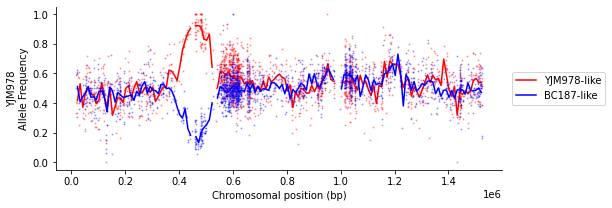

In [60]:
chrom = 'IV' # I already know there is a QTL here
binwidth = 10000 # in bp

dfchrom = df[df['CHROM']==chrom]

fig,ax = plt.subplots(1,1,figsize=(8,3));

x = dfchrom['POS']

# YJM-like pool
for pool,color in zip(['YJM978-like','BC187-like'], 
                      ['r','b']):
    # dots for each SNP
    total = dfchrom[pool+'_BC187_count']+dfchrom[pool+'_YJM978_count']
    y = dfchrom[pool+'_YJM978_count']/total.astype(float)
    ax.plot(x,y,'.',markersize=2,alpha=0.3,c=color);

    # lines for binned averages
    n = int(np.ceil((max(x)-min(x))/float(binwidth)))
    xbins = np.linspace(min(x),min(x)+n*binwidth,n+1)
    ybins = binned_statistic(x,y,statistic=np.mean,bins=xbins)[0]
    ax.plot(xbins[:-1]+binwidth/2.,ybins,'-',c=color,label=pool);

ax.set_ylabel('YJM978\nAllele Frequency')
ax.set_xlabel('Chromosomal position (bp)')
lgd = ax.legend(loc='center left',bbox_to_anchor=(1.01,0.5))
box_off(ax)

In [27]:
fig.savefig(figdir+'allele_freq_chr'+chrom,dpi=200,bbox_extra_artists=[lgd],bbox_inches='tight')

### Allele frequency, genomewide
Make the above plot over all 16 chromosomes.

#### Get chromosome lengths and plotting offsets

In [61]:
def get_chr_info():
    from Bio import SeqIO
    import re
    reclist = []
    seqlist = list(SeqIO.parse(datadir+'sacCer3.fa','fasta'))
    chrnames = np.array([s.id for s in seqlist])
    for c in ['I','II','III','IV','V','VI','VII','VIII','IX','X','XI','XII','XIII','XIV','XV','XVI','M']:
        i, = np.where(chrnames=='chr'+c)
        chrom = seqlist[i[0]]
        reclist.append({
                'Chromosome':c,
                'Length':len(chrom),
            })
    dfchr = pd.DataFrame.from_records(reclist)
    dfchr['Offset'] = np.insert(np.cumsum(dfchr['Length'].values)[:-1],0,0)
    dfchr.index = dfchr['Chromosome']
    dfchr = dfchr.drop(['Chromosome'],axis=1)
    return dfchr

In [62]:
dfchr = get_chr_info()

#### Make plot

Function to plot one chromosome (based on above code)

In [68]:
def plot_allelefreq_chrom(df, dfchr, chrom, ax, 
                          color='b', binwidth=5000, offsetx=True, plotdots=True, label=None):
    from scipy.stats import binned_statistic
    
#     i, = np.where(dfchr.index==chrom)
#     chr_end = dfchr.loc[dfchr.index[i+1],'Offset']        
    dfchrom = df[df['CHROM']==chrom]
    x = dfchrom['POS']    
    offset = dfchr.loc[chrom,'Offset'] if offsetx else 0
    
    # dots for each SNP
    total = dfchrom[pool+'_BC187_count']+dfchrom[pool+'_YJM978_count']
    y = dfchrom[pool+'_YJM978_count']/total.astype(float)
    if plotdots:
        ax.plot(x+offset,y,'.',markersize=2,alpha=0.3,c=color);

    # lines for binned averages
    n = int(np.ceil((max(x)-min(x))/float(binwidth)))
    xbins = np.linspace(min(x),min(x)+n*binwidth,n+1)
    ybins = binned_statistic(x,y,statistic=np.mean,bins=xbins)[0]
    ax.plot(xbins[:-1]+binwidth/2.+offset,ybins,'-',c=color,label=label);

    box_off(ax)

Plot data across all chromosomes

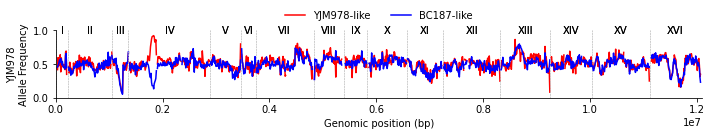

In [69]:
fig,ax = plt.subplots(1,1,figsize=(10,2));

for chrom in dfchr.index[:-1]: # omit mitochondrial chromosome
    for pool,color in zip(['YJM978-like','BC187-like'], 
                          ['r','b']):
        ax.plot([dfchr.loc[chrom,'Offset'],dfchr.loc[chrom,'Offset']],[0,1],'--',c=[.75]*3,linewidth=0.5);
        ax.text(dfchr.loc[chrom,'Offset']+dfchr.loc[chrom,'Length']/2.,.95,chrom,ha='center')
        label = pool if chrom==dfchr.index[-2] else None
        plot_allelefreq_chrom(df, dfchr, chrom, ax,
                              color=color, binwidth=10000, plotdots=False, label=label)
ax.set_xlim([0,1.21e7])
ax.set_ylim([0,1])
ax.set_ylabel('YJM978\nAllele Frequency')
ax.set_xlabel('Genomic position (bp)')
lgd = ax.legend(ncol=2,loc='lower center',bbox_to_anchor=(0.5, 1.01),fontsize=10,frameon=False)
plt.tight_layout()

In [32]:
fig.savefig(figdir+'allele_freq_genome',dpi=200,bbox_extra_artists=[lgd],bbox_inches='tight')

### Allele frequency difference
QTLs are easier to see if we take a difference of the two segregant pools.

In [70]:
def plot_allelefreqdiff_chrom(df, dfchr, chrom, ax, 
                          color='k', binwidth=5000, offsetx=True, plotdots=True):
    from scipy.stats import binned_statistic

    dfchrom = df[df['CHROM']==chrom]
    x = dfchrom['POS']
    offset = dfchr.loc[chrom,'Offset'] if offsetx else 0

    y = []
    for pool in ['YJM978-like','BC187-like']: 
        total = dfchrom[pool+'_BC187_count']+dfchrom[pool+'_YJM978_count']
        y.append(dfchrom[pool+'_YJM978_count']/total.astype(float))
    ydiff = y[0]-y[1]

    if plotdots:
        ax.plot(x+offset,ydiff,'.',markersize=2,alpha=0.3,c=color);

    # lines for binned averages
    n = int(np.ceil((max(x)-min(x))/float(binwidth)))
    xbins = np.linspace(min(x),min(x)+n*binwidth,n+1)
    ybins = binned_statistic(x,ydiff,statistic=np.mean,bins=xbins)[0]
    ax.plot(xbins[:-1]+binwidth/2.+offset,ybins,'-',c=color);

    box_off(ax)

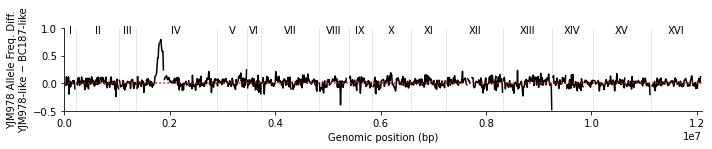

In [71]:
fig,ax = plt.subplots(1,1,figsize=(10,2));

for chrom in dfchr.index[:-1]: # omit mitochondrial chromosome
    ax.plot([dfchr.loc[chrom,'Offset'],dfchr.loc[chrom,'Offset']],[-1,1],'--',c=[.75]*3,linewidth=0.5);
    ax.text(dfchr.loc[chrom,'Offset']+dfchr.loc[chrom,'Length']/2.,.9,chrom,ha='center')
    label = pool if chrom==dfchr.index[-2] else None
    plot_allelefreqdiff_chrom(df, dfchr, chrom, ax, binwidth=10000, plotdots=False)
ax.set_xlim([0,1.21e7])
ax.plot(ax.get_xlim(),[0,0],'r:')
ax.set_ylim([-.5,1])
ax.set_ylabel(u'YJM978 Allele Freq. Diff.\nYJM978-like \u2212 BC187-like') # unicode minus sign
ax.set_xlabel('Genomic position (bp)')
plt.tight_layout()

In [35]:
fig.savefig(figdir+'allele_freq_diff_genome',dpi=200)

From this plot it is clear that there is one major QTL on chromosome IV. However, even the binned allele frequency differences are somewhat noisy, and it's hard to see if there are other QTLs.

A more rigorous analysis would compute a statistic for the hypothesis that allele frequencies between the two pools differ given the noise in the data from various sources -- e.g. sequencing noise, finite number of segregants, etc. Fortunately, this is performed by the 3rd-party tool MULTIPOOL, which we will use below.

## Plot LOD scores
Compute statistical significance of the observed allele frequency differences using [MULTIPOOL](https://github.com/matted/multipool) ([Edwards et al. 2012](http://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-13-S6-S8)), which is available as a Python script `mp_inference.py`.

### Load data

In [72]:
df = load_vcf(datadir+'GxB.vcf')

In [73]:
df.shape

(63000, 13)

In [74]:
df = parse_snp_table(df, parent_names = ['YJM978','BC187'])

In [75]:
df.shape

(13860, 11)

### Calculate LOD scores

#### Try code on 1 chromosome

Take a look at data again to recall the columns.

In [76]:
df.iloc[:1]

,CHROM,POS,REF,ALT,QUAL,YJM978_allele,BC187_allele,YJM978-like_YJM978_count,YJM978-like_BC187_count,BC187-like_YJM978_count,BC187-like_BC187_count
I_27822,I,27822,T,C,454.0,0,1,1,3,5,10


Output allele counts to use as input to `mp_inference.py`

In [78]:
chrom = 'IV'
dfchrom = df[df['CHROM']==chrom]
pool_names = ['YJM978-like','BC187-like']

for pool in pool_names:
    fn = '%s_chr%s.txt' % (pool,chrom)
    with open(fn,'w') as f:
        for i,row in dfchrom.iterrows():
            print('%s\t%d\t%d' % (row['POS'],row[pool+'_YJM978_count'],row[pool+'_BC187_count']), file=f)

Use subprocess to run `mp_inference.py` as a shell command. The options we're using are the same as those in 2 recent papers ([Albert et al. 2014](http://www.nature.com/nature/journal/v506/n7489/abs/nature12904.html); [Treusch et al. 2015](http://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1004913)). These are explained in the [MULTIPOOL documentation](https://github.com/matted/multipool).

The script's terminal output contains some summary statistics, but the more important output, the LOD scores over genomic locations, is written to a file. We capture both in the code below, but only use the latter.

It is probably faster / more elegant to run the internal functions directly through Python, but this usage is not intended or documented by the authors so we opt for the clunky (but surefire) method.

In [79]:
from subprocess import Popen,PIPE

In [40]:
fn1 = '%s_chr%s.txt' % (pool_names[0],chrom)
fn2 = '%s_chr%s.txt' % (pool_names[1],chrom)

multipool = Popen(['python','mp_inference.py',
                   '--noPlot',
                   '--resolution', '100',
                   '--centimorgan', '2200',
                   '--individuals', '1000',
                   '--mode','contrast',
                   '--output','temp.txt',
                   fn1, fn2],
                  stdout=PIPE,stderr=PIPE)
stdout, stderr = multipool.communicate()

In [41]:
dflod_chrom = pd.read_table('temp.txt')

In [42]:
dflod_chrom.insert(0,'Chromosome',chrom)

In [43]:
dflod_chrom.iloc[:5]

,Chromosome,Bin start (bp),MLE allele freq.,LOD score
0,IV,17200,0.4250,0.57
1,IV,17300,0.4225,0.57
2,IV,17400,0.4225,0.57
3,IV,17500,0.4225,0.57
4,IV,17600,0.4225,0.57


Great, code is working. Now write a function to loop over all chromosomes.

#### Function run_multipool
This takes the above code snippet and runs it for every chromosome. A lot of temporary files are generated but they are deleted after being loaded back into a DataFrame.

In [44]:
def run_multipool(df, parent_names, pool_names):
    from subprocess import Popen,PIPE
    import os
    
    dflod = pd.DataFrame()
    dfchr = get_chr_info()
    for chrom in dfchr.index[:-1]: # exclude mitochondrial chromosome
        dfchrom = df[df['CHROM']==chrom]

        for pool in pool_names:
            # Output allele counts to use as input to mp_inference.py
            fn = 'mp_%s_chr%s.txt' % (pool,chrom)
            with open(fn,'w') as f:
                for i,row in dfchrom.iterrows():
                    print >>f, '%s\t%d\t%d' % (row['POS'],
                                               row[pool+'_'+parent_names[0]+'_count'],
                                               row[pool+'_'+parent_names[1]+'_count'])
        
        # run MULTIPOOL
        fn1 = 'mp_%s_chr%s.txt' % (pool_names[0],chrom)
        fn2 = 'mp_%s_chr%s.txt' % (pool_names[1],chrom)
        multipool = Popen(['python','mp_inference.py',
                           '--noPlot',
                           '--resolution', '100',
                           '--centimorgan', '2200',
                           '--individuals', '1000',
                           '--mode','contrast',
                           '--output','temp.txt',
                           fn1, fn2],
                          stdout=PIPE,stderr=PIPE)
        stdout, stderr = multipool.communicate()

        # save results
        dflod_chrom = pd.read_table('temp.txt')
        dflod_chrom.insert(0,'Chromosome',chrom)
        dflod = dflod.append(dflod_chrom)
        
        # clean up 
        os.remove(fn1)
        os.remove(fn2)
        os.remove('temp.txt')
    return dflod

#### Get LOD scores and save

In [45]:
dflod = run_multipool(df,parent_names=['YJM978','BC187'], pool_names=['YJM978-like','BC187-like'])

In [46]:
dflod.to_csv(datadir+'LOD_scores.csv.gz',compression='gzip')

### Plot LOD scores

Load the LOD score table again and look at the column names.

In [83]:
dflod = pd.read_csv(datadir+'LOD_scores.csv.gz',index_col=0)

In [84]:
dflod.iloc[:1]

,Chromosome,Bin start (bp),MLE allele freq.,LOD score
0,I,27800,0.48,0.44


In [85]:
dflod.shape

(117025, 4)

There are a lot of points (due to MULTIPOOL computing statistics at every 100bp). We can subsample these and have the same-looking plot. This will make things faster and save disk space if saving a vector graphic.

In [89]:
def plot_lod_chrom(dflod, dfchr, chrom, ax, 
                          color='b', offsetx=True, label=None):
    dfchrom = dflod[(dflod['Chromosome']==chrom)]
    
    x = dfchrom['Bin start (bp)'][::100] # plot every 100th point
    offset = dfchr.loc[chrom,'Offset'] if offsetx else 0
    y = dfchrom['LOD score'][::100]
    ax.plot(x+offset,y,'-',c=color,label=label);

    box_off(ax)

Plot data across all chromosomes

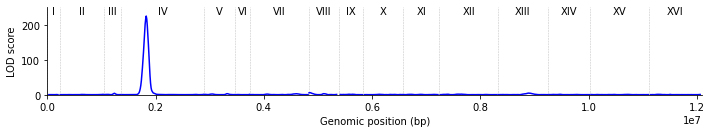

In [90]:
fig,ax = plt.subplots(1,1,figsize=(10,2));

for chrom in dfchr.index[:-1]: # omit mitochondrial chromosome
    ax.plot([dfchr.loc[chrom,'Offset'],dfchr.loc[chrom,'Offset']],[0,250],'--',c=[.75]*3,linewidth=0.5);
    ax.text(dfchr.loc[chrom,'Offset']+dfchr.loc[chrom,'Length']/2.,230,chrom,ha='center')
    label = pool if chrom==dfchr.index[-2] else None
    plot_lod_chrom(dflod, dfchr, chrom, ax)
ax.set_xlim([0,1.21e7])
ax.set_ylim([0,250])
ax.set_ylabel('LOD score')
ax.set_xlabel('Genomic position (bp)')
plt.tight_layout()

In [52]:
fig.savefig(figdir+'lod_genome',dpi=200)

This plot is easy to interpret because there is one locus (on ChrIV) with a much higher LOD score than anywhere else in the genome. This corroborates our conclusion above from looking at the allele frequency differences.

In practice, there are usually multiple significant loci, and some calculation of the false discovery rate is informative. Albert et al. and Treusch et al. provide examples of how to do this.

In this dataset, it is obvious that one QTL is worth following up on, so let's figure out where it is and what genes are there.

## Look at QTL genes
The next step is to examine the genes near each QTL, typically defined by taking LOD-support intervals. Here, we'll look at the 3-LOD-support interval for the QTL on chromosome IV, or the region where the LOD is within 3 units of its peak value. The choice of the cutoff is arbitrary -- some papers might use 1- or 2-LOD support intervals instead.

### Determine 3-LOD support interval coordinates

In [91]:
dfsub = dflod[dflod['Chromosome']=='IV']

In [92]:
idx = np.argmax(dfsub['LOD score'])
bp_peak = dfsub['Bin start (bp)'][idx]
lod_peak = dfsub['LOD score'][idx]

In [93]:
idx, = np.where(dfsub['LOD score'] > lod_peak-3)
lod_sup_int = (dfsub['Bin start (bp)'][idx[0]],dfsub['Bin start (bp)'][idx[-1]])
lod_sup_int

(462600, 473300)

### Plot gene annotations

To actually look at genes, we download a table of yeast genome annotations, `SGD_features.tab`, from [SGD](http://yeastgenome.org/download-data/sequence). Annoyingly, this file doesn't contain column headers, but these are described [somewhere else](http://downloads.yeastgenome.org/curation/chromosomal_feature/SGD_features.README) so we will add them manually below.

#### Load SGD annotations

In [94]:
dfannot = pd.read_table(datadir+'SGD_features.tab',header=None)

In [95]:
dfannot.iloc[:1]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,S000002143,ORF,Dubious,YAL069W,NaN,NaN,chromosome 1,NaN,1,335.0,649.0,W,NaN,1996-07-31,1996-07-31,Dubious open reading frame; unlikely to encode...


In [96]:
dfannot.columns = ['SGD ID','Type','Qualifier','Name','Standard gene name',
                   'Alias','Parent feature name','Secondary ID','Chromosome',
                   'Start_coordinate','Stop_coordinate','Strand','Genetic position','Coordinate version',
                   'Sequence version','Description']

Just take the columns we need and keep only "ORF" annotations (i.e. exclude ARSs, transposable elements, etc)

In [97]:
dfannot = dfannot[['Name','Standard gene name','Type','Chromosome','Start_coordinate','Stop_coordinate','Strand','Description']]
dfannot = dfannot[dfannot['Type']=='ORF']

In [98]:
dfannot.iloc[:1]

,Name,Standard gene name,Type,Chromosome,Start_coordinate,Stop_coordinate,Strand,Description
0,YAL069W,NaN,ORF,1,335.0,649.0,W,Dubious open reading frame; unlikely to encode...


#### Make plot

Annotations that are strictly inside our LOD support interval.

In [99]:
chrom = 'IV'
chromnum = '4' # SGD annotations have arabic numeral chromosome numbers

dfsub = dfannot[(dfannot['Chromosome']==chromnum)
                & (np.minimum(dfannot['Start_coordinate'],dfannot['Stop_coordinate']) > lod_sup_int[0])
                & (np.maximum(dfannot['Start_coordinate'],dfannot['Stop_coordinate']) < lod_sup_int[1])]

In [62]:
dfsub

,Name,Standard gene name,Type,Chromosome,Start_coordinate,Stop_coordinate,Strand,Description
10948,YDR009W,GAL3,ORF,4,463434.0,464996.0,W,Transcriptional regulator; involved in activat...
10950,YDR010C,NaN,ORF,4,465383.0,465051.0,C,Dubious open reading frame; unlikely to encode...
10952,YDR011W,SNQ2,ORF,4,465919.0,470424.0,W,Plasma membrane ATP-binding cassette (ABC) tra...
10954,YDR012W,RPL4B,ORF,4,471853.0,472941.0,W,Ribosomal 60S subunit protein L4B; homologous ...


Plot the genes as pointed arrows, forward and reverse oriented genes on different tracks.

In [100]:
lod_sup_int = [461300,472400]

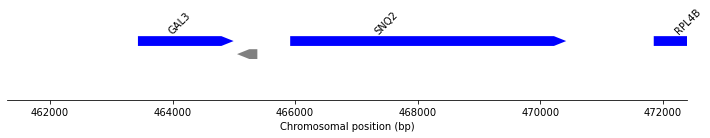

In [101]:
fig,ax = plt.subplots(1,1,figsize=(10,2));

w = 1.5
head_length = 200
for i,row in dfsub.iterrows():
    startpos = row['Start_coordinate']
    length = row['Stop_coordinate']-row['Start_coordinate']
    direction = -1 if length < 1 else 1
    name = row['Standard gene name']
    if type(name) is str:
        facecolor = 'b'
        ax.annotate(name,[startpos+0.5*length-0.2*abs(length)*direction, 1.8*direction],rotation=45,
                    ha='left' if direction==1 else 'right',
                    va='bottom' if direction==1 else 'top')
    else:
        facecolor = 'gray'
    ax.arrow(startpos, direction,
              length - direction*head_length, 0,
              fc=facecolor, ec='none', alpha=1, width=w, head_width=w, head_length=head_length)
ax.set_xlim(lod_sup_int)
ax.set_ylim([-8,6])

ax.yaxis.set_visible(False)
ax.set_xlabel('Chromosomal position (bp)')
box_off(ax)
ax.spines['left'].set_visible(False)
plt.tight_layout()

In [65]:
fig.savefig(figdir+'ChrIV_468k_LodSupInt',dpi=200)

It looks like our LOD support interval is centered on SNQ2. (In fact, if we had used a 2-LOD support interval, this would be the only gene in the interval.) However, based on our phenotype (GAL1 promoter reporter expression) and the literature, we know that GAL3 is much more likely to be the causative gene in this locus.

As you can see, some amount of user judgement and experimental followup is needed at this stage to get further mechanistic insight into the results of the bulk segregant analysis. This is a pretty typical situation of genetic mapping studies. The hard part isn't mapping a locus (which we just did), identifying the causative genes afterward and ultimately, understanding the mechanism.